In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import GlobalAveragePooling2D as GAP2D
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.optimizers import AdamW, Adam #, Lion

In [2]:
ind_to_name = {                  # ImageNet file names \/
    0:'shark',                   # n01484850
    1:'chicken',                 # n01514859
    2:'bird',                    # n01530575
    3:'eagle',                   # n01614925
    4:'owl',                     # n01622779
    5:'lizard',                  # n01629819
    6:'turtle',                  # n01665541
    7:'wolf',                    # n02114367
    8:'lion',                    # n02129165
    9:'tiger',                   # n02129604
    10:'grizzly',                # n02132136
    11:'polar bear',             # n02134084
    12:'horse',                  # n02389026
    13:'elephant',               # n02504458
    14:'battleship/carrier'      # n02687172
}

In [3]:
"""
model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3))
"""
model1 = load_model('C:/Users/movse/Anaconda projects/EffNetB0_NoTop.h5')
for l in model1.layers:
    l.trainable = False
#model1.summary()

In [4]:
def build_top(out_shape, optmz):
    inp = tf.keras.Input(shape=(224, 224, 3))
    x = model1(inp)
    x = GAP2D(name='Top_Globl_Avg')(x)
    x = Dense(64, activation='relu', name='Top_Dense')(x)
    x = Dropout(0.15, name='Top_Dropout')(x)
    x = Dense(out_shape, activation='softmax', name='Final_Dense')(x)
    mdl = tf.keras.Model(inp, x)
    mdl.compile(optimizer=optmz,
                loss='categorical_crossentropy',
                metrics=['AUC', 'acc'])
    return mdl

In [5]:
modelA = build_top(15, AdamW())

In [6]:
modelA.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 Top_Globl_Avg (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 Top_Dense (Dense)           (None, 64)                81984     
                                                                 
 Top_Dropout (Dropout)       (None, 64)                0         
                                                                 
 Final_Dense (Dense)         (None, 15)                975       
                                                             

In [7]:
import os
from PIL import Image
import numpy as np
from IPython.display import clear_output

imgnet_path = 'D:/ImageNet/images/'
imgs = []
y = []
for ind, files in enumerate(os.listdir(imgnet_path)):
    for ind1, img in enumerate(os.listdir(imgnet_path+files)):
        q = Image.open(imgnet_path + files + "/" + img)
        q = q.resize((224, 224)).convert('RGB')
        imgs.append(np.array(q))
        y.append(ind)
        
        print(ind, '/ 15', ind1, '/ 1300')
        clear_output(wait = True)

14 / 15 1299 / 1300


In [8]:
imgs = np.array(imgs)
imgs.shape

(19500, 224, 224, 3)

In [9]:
y = np.array(y)
y = tf.one_hot(y, 15)
y.shape

TensorShape([19500, 15])

In [10]:
np.random.seed(1)
indxs = np.random.rand(imgs.shape[0])<0.1

In [11]:
X_train, X_test, y_train, y_test = imgs[np.invert(indxs)], imgs[indxs], y[np.invert(indxs)], y[indxs]

In [12]:
#tf.config.run_functions_eagerly(True)
tf.keras.utils.set_random_seed(1)
modelA.fit(X_train, y_train,
          epochs=1,
          batch_size=32,
          #validation_split=0.1,
          validation_data=(X_test, y_test),
          shuffle=True,
          verbose=1)

549/549 [==============================] - 231s 415ms/step - loss: 0.1513 - auc: 0.9990 - acc: 0.9683 - val_loss: 0.0470 - val_auc: 0.9997 - val_acc: 0.9851


In [13]:
for l in modelA.layers:
    l.trainable = True
modelA.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 Top_Globl_Avg (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 Top_Dense (Dense)           (None, 64)                81984     
                                                                 
 Top_Dropout (Dropout)       (None, 64)                0         
                                                                 
 Final_Dense (Dense)         (None, 15)                975       
                                                             

In [14]:
modelA.optimizer = AdamW(0.0001)
modelA.fit(X_train, y_train,
           epochs=1,
           batch_size=256,
           validation_data=(X_test, y_test),
           shuffle=True,
           verbose=1)

69/69 [==============================] - 218s 3s/step - loss: 0.0341 - auc: 0.9998 - acc: 0.9907 - val_loss: 0.0422 - val_auc: 0.9997 - val_acc: 0.9872


In [15]:
pred = modelA.predict(X_test)

61/61 [==============================] - 23s 359ms/step


In [16]:
diff = tf.math.argmax(pred, 1) != tf.math.argmax(y_test, 1)

In [17]:
X_test[diff].shape

(25, 224, 224, 3)

predicted - polar bear 
reality - wolf


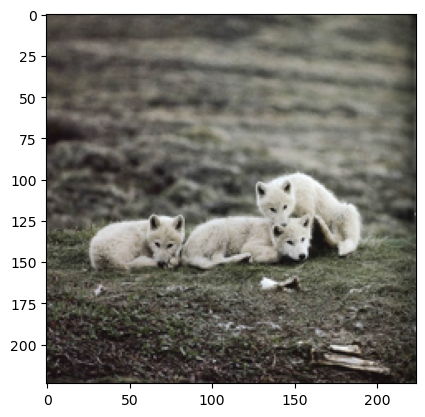

In [30]:
from matplotlib import pyplot as plt

ind = 12
plt.imshow(X_test[diff][ind])
real = tf.math.argmax(y_test, 1)[diff][ind]
pred1 = tf.math.argmax(pred, 1)[diff][ind]

print('predicted -', ind_to_name[int(pred1)], '\nreality -', ind_to_name[int(real)])